# Eigenfaces

This example demostrates some simplistic generative models applied to the Olivetti faced dataset.

This is done in three ways:

  - We assume that the data is sampled from a multigaussian distribution, and sample from the maximum likelihood distribution.
  - We do the same, but compress our latent space using PCA.
  - We consider some Gaussian mixture model, taking care to work in a latent space that is free of singularities.


Some optional tasks could be:

  - Explore the effect of changing the number of components in PCA.
 


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState

import scipy.linalg as la
import scipy.stats
from sklearn.datasets import fetch_olivetti_faces



rng = RandomState(0)

faces, _ignore = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

img_shape = (64, 64)

mean_face = faces.mean(axis=0)


In [2]:
def plot_face(img):
    fig, ax = plt.subplots()
    ax.imshow(img.reshape(img_shape))

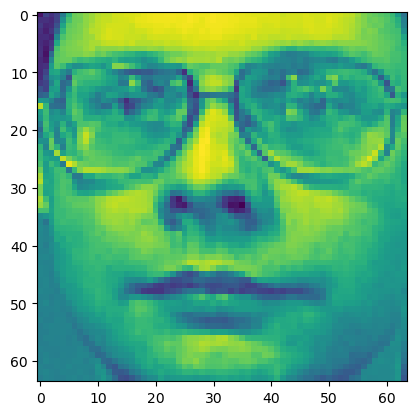

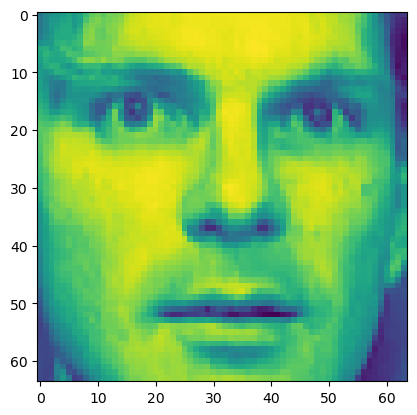

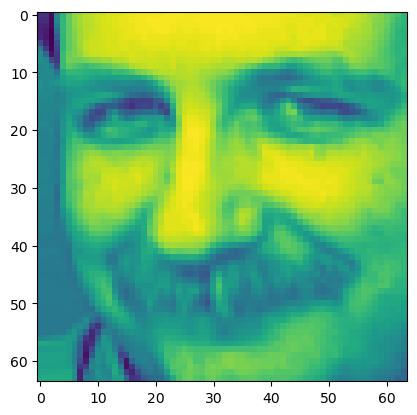

In [3]:
# Plot some examples
plot_face(faces[10])
plot_face(faces[20])
plot_face(faces[50])

#### Mean face

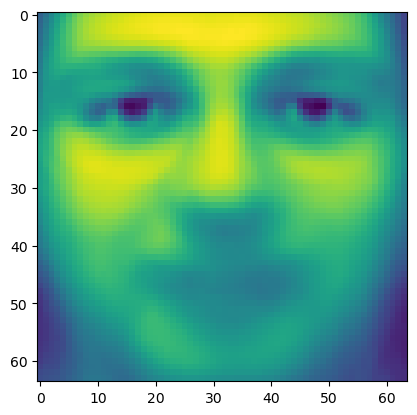

In [4]:
plot_face(mean_face)

In [5]:
faces_centered = faces - mean_face


### Covariance matrix

#### Sample covariance from definition

In [6]:

cov = faces_centered.T@faces_centered/(n_samples - 1)

#### Covariance from reduced data matrix

In [7]:
X = faces_centered/np.sqrt(n_samples - 1)

In [8]:
np.allclose(X.T @ X, cov)

True

#### Compute using numpy

In [9]:
cov2 = np.cov(faces, rowvar=False)

In [10]:
np.allclose(cov2, cov)

True

## Singular value decomposition

In [12]:
svd = u, s, vt = la.svd(X, full_matrices=False)

In [13]:
u.shape

(400, 400)

In [14]:
s.shape

(400,)

In [15]:
vt.shape

(400, 4096)

Within numerical precision, we can combine the returned result as

In [16]:
reconstructed_X = (u*s)@vt

In [17]:
np.allclose(reconstructed_X, X, atol=1e-6)

True

### Look into some statistcs of singular values

Note that the scales of the singular values are very different

In [18]:
s.min()

9.890124e-06

In [19]:
s.max()

4.3405256

In [20]:
s[:10]

array([4.3405256, 3.327427 , 2.5108967, 1.9886118, 1.6899819, 1.5804127,
       1.3856641, 1.2693148, 1.2446775, 1.1501961], dtype=float32)

In [21]:
s[-10:]

array([4.6270281e-02, 4.5357961e-02, 4.4393193e-02, 4.3577440e-02,
       4.1764934e-02, 4.1496031e-02, 4.1161671e-02, 3.9802611e-02,
       3.6018699e-02, 9.8901237e-06], dtype=float32)

### Gausian sampling

In [22]:
def sample_faces_full(X, mean, n_samples):
    return np.random.standard_normal((n_samples, s.shape[0] ))@X + mean

## PCA

In [23]:
def keep_n_components(svd, n_components):
    u, s, vt = svd
    return (u[:n_components, :n_components], s[:n_components], vt[:n_components, :])


def reduce_svd(svd, n_components):
    u_red, s_red, vt_red = keep_n_components(svd, n_components)
    return (u_red*s_red)@vt_red
    

In [24]:
def sample_faces_pca(svd, n_components, mean, n_samples):
    
    X_red = reduce_svd(svd, n_components)
    
    out_shape = (n_samples, X_red.shape[0])
    return np.random.standard_normal(out_shape)@X_red + mean

In [25]:
n_samples = 500

In [26]:
full_samples = sample_faces_full(X, mean_face, 10)

### Faces with full covariance

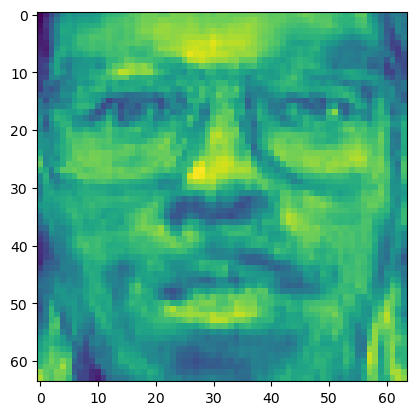

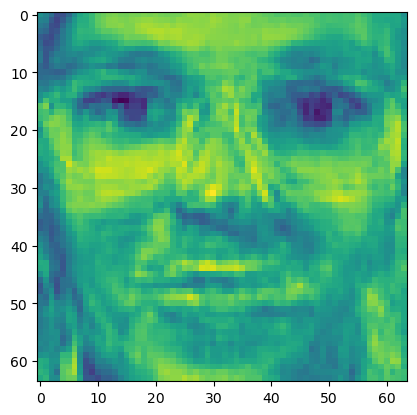

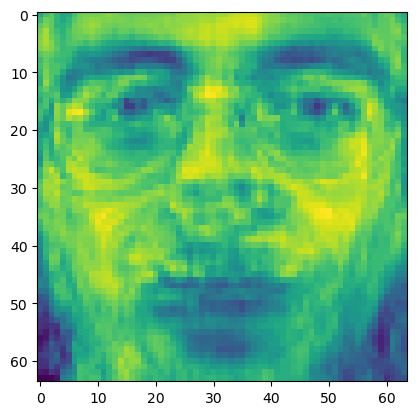

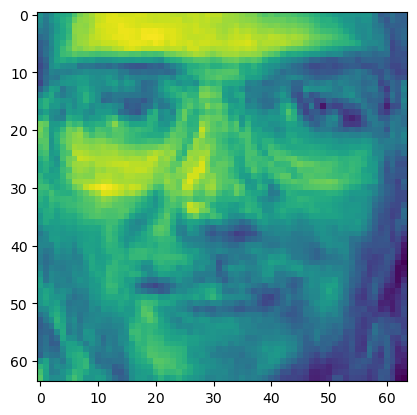

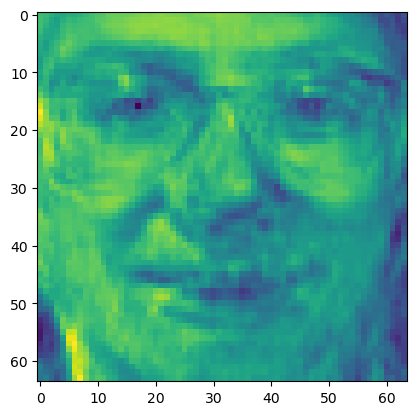

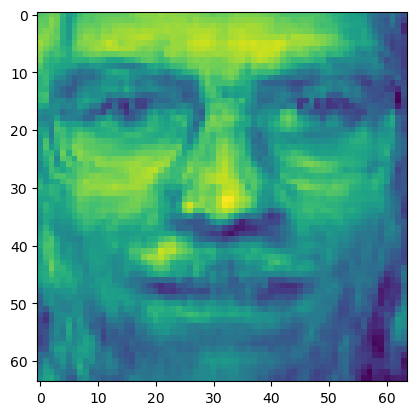

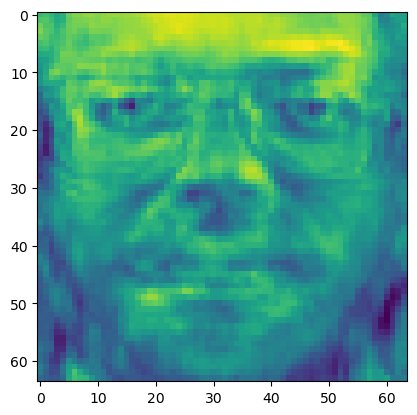

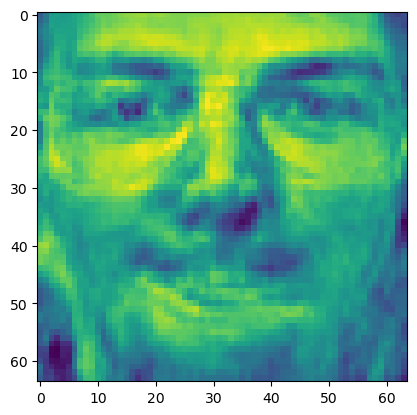

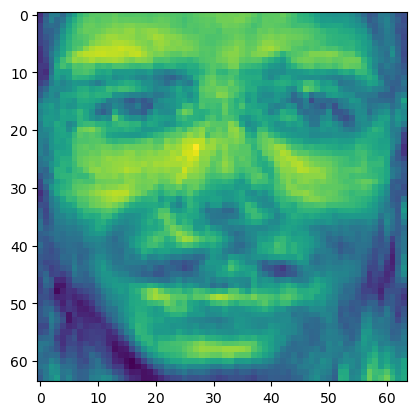

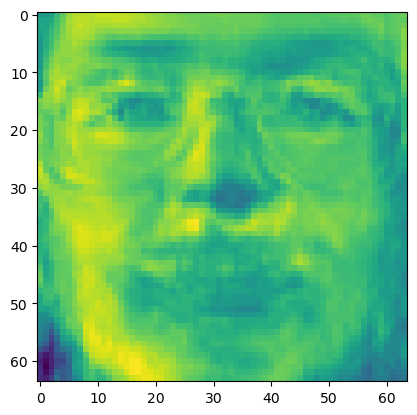

In [29]:

for face_sample in full_samples:
    plot_face(face_sample)

### Faces with PCA

In [32]:
svd_samples = sample_faces_pca(svd, n_components=50, mean=mean_face, n_samples=10)

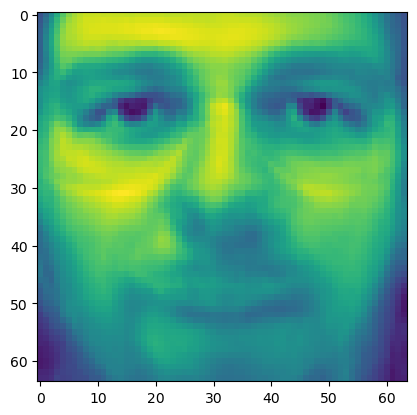

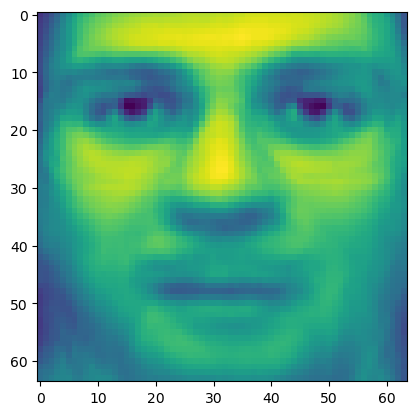

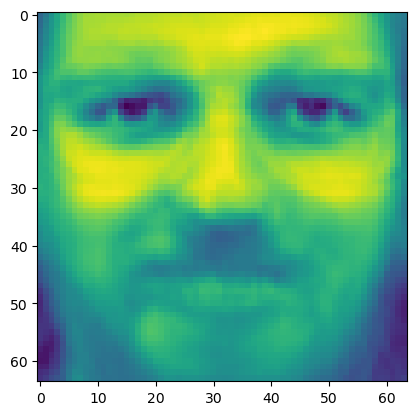

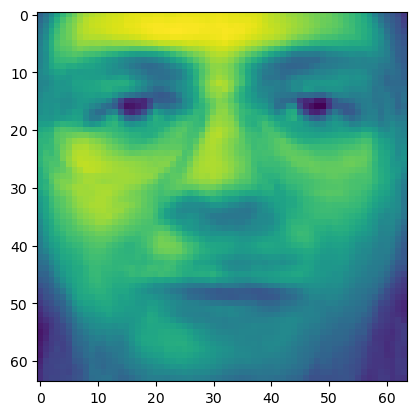

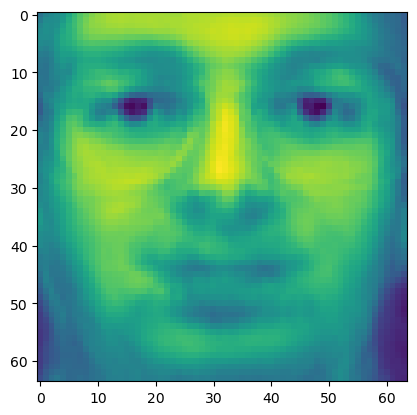

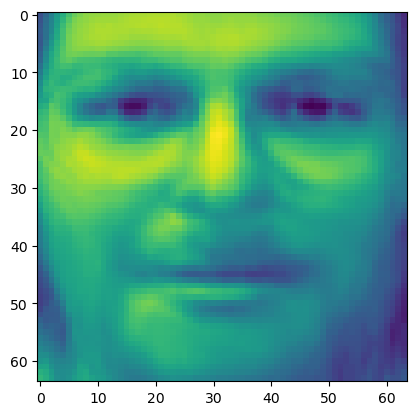

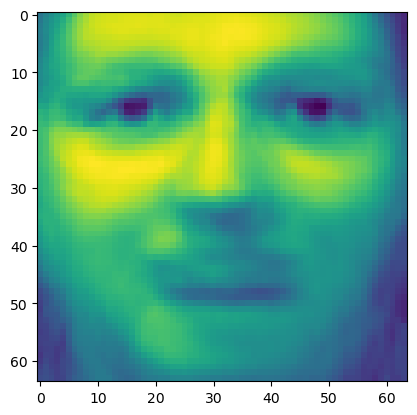

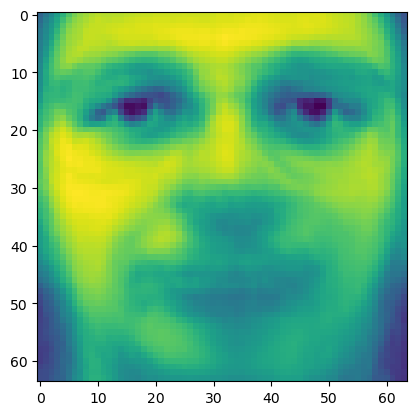

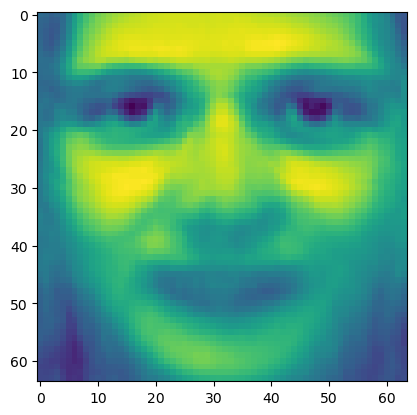

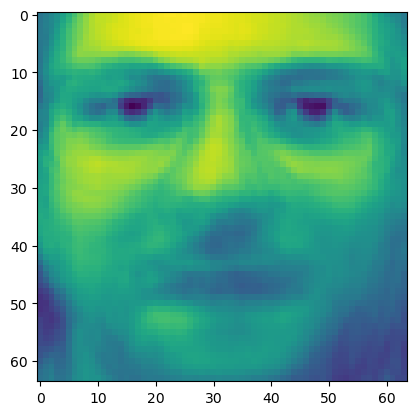

In [33]:
for face_sample in svd_samples:
    plot_face(face_sample)

## Gaussian mixture and Expectation-Maximization

We don't have a particularly strong reason to assume that the data is Gaussian.

### Looking at random pixels

If the distribution of images is muligaussian, then each pixel in isolation should be Gaussian.

In [ ]:
for _ in range(3):
    fig, ax  = plt.subplots()
    random_pixel_index = np.random.randint(faces.shape[1])
    random_pixel_values = faces[:, random_pixel_index]
    ax.hist(random_pixel_values)
    ax.set_xlabel("Pixel values")

It is clear that this doesn't seem to be the case.

**Optional exercise**: Come up with a more quantitative estiamate of the "gaussiantiy" of each pixel.

## Trying Gaussian mixtures

In [40]:
from sklearn.mixture import GaussianMixture

#### What *not to do*


The space of faces is going to involve singular covariance matrices, as seen above.

```python
#gmm = GaussianMixture(n_components=3)
#gmm.fit(faces)
#gmm.sample(10)
```

Instead work on a reduced space that encodes most of the information, but has no singularities.

In [52]:
svd_full = la.svd(faces)

In [53]:
u_red, s_red, v_red = keep_n_components(svd_full, n_components=300)

In [54]:
encoded_images = u_red*s_red

In [55]:
gmm = GaussianMixture(n_components=2)

In [56]:
gmm.fit(encoded_images)

GaussianMixture(n_components=2)

In [57]:
gmm.weights_

array([0.65666667, 0.34333333])

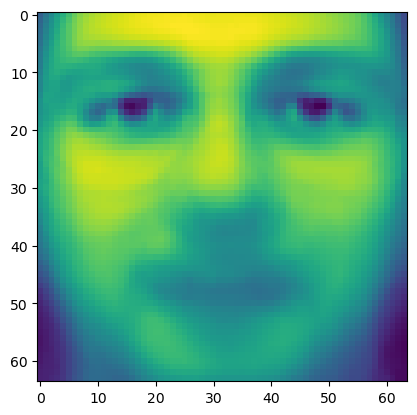

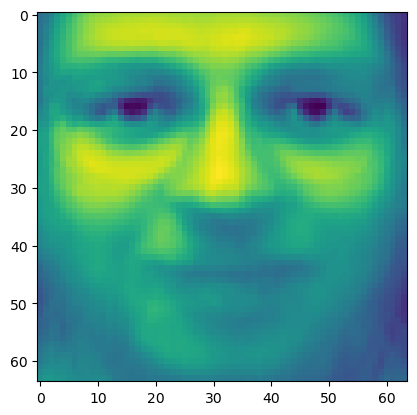

In [58]:
for im in gmm.means_@v_red:
    plot_face(im)

In [59]:
samples, _ = gmm.sample(10)

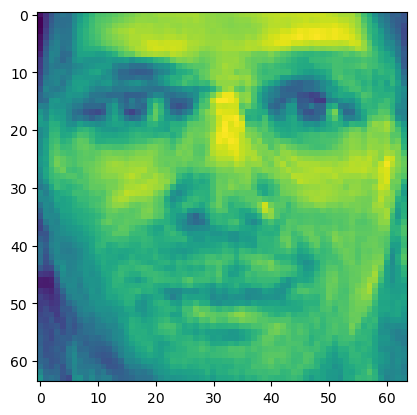

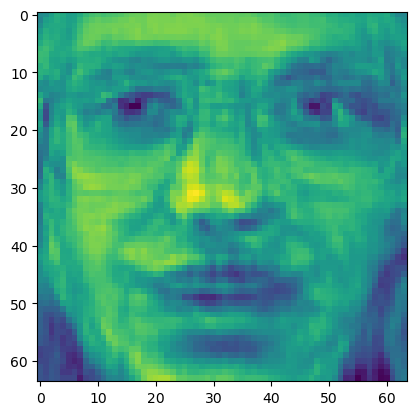

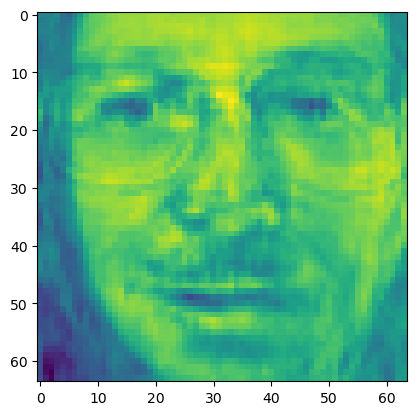

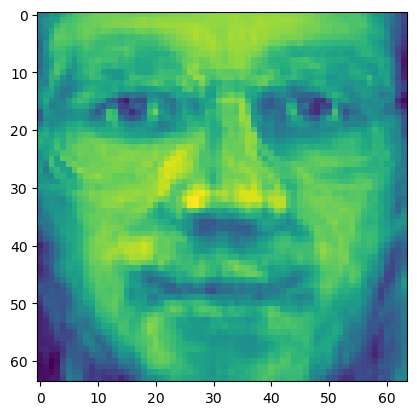

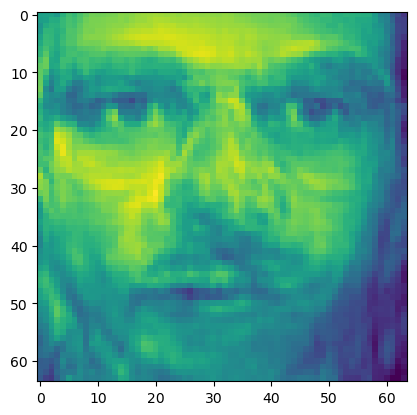

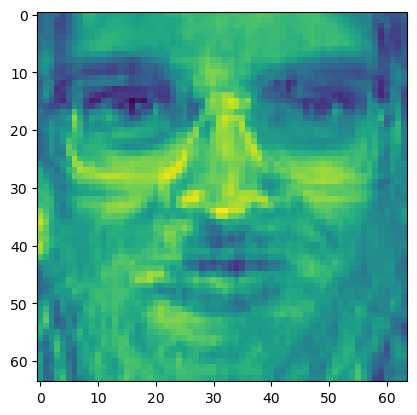

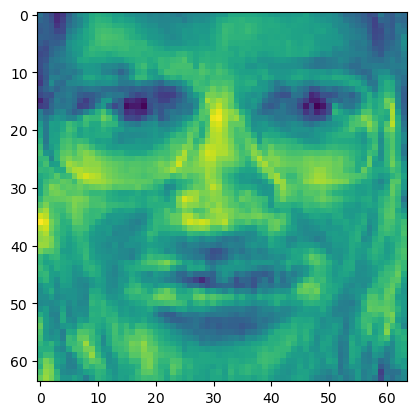

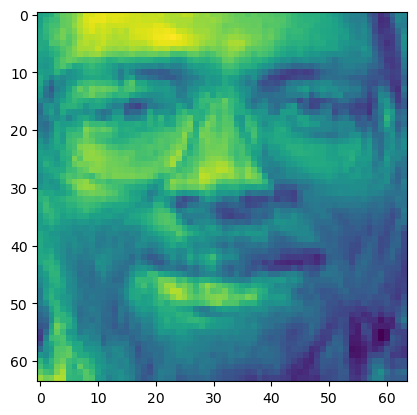

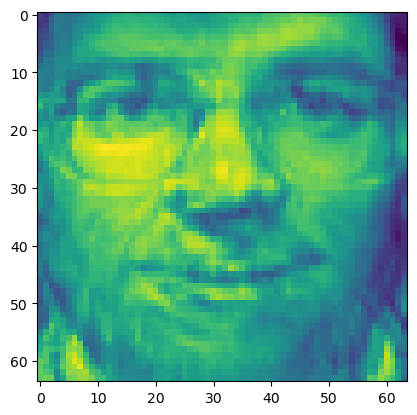

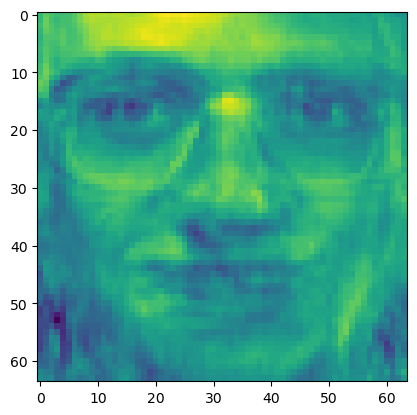

In [60]:
for im in samples@v_red:
    plot_face(im)